In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from models.pruning import Pruning
from utils.visualization import plot_sensitivity_analysis
import json

In [35]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1').to(DEVICE).eval()

## Model Exploration

In [37]:

# Define a function to calculate memory usage of a model
def compute_memory_usage(model, input_size=(3, 640, 640), batch_size=1):
    print(f"{'Layer':<30}{'Output Shape':<30}{'Param Count':<15}{'Weights (MB)':<15}{'Activations (MB)':<15}")
    print("-" * 100)
    
    total_params = 0
    total_weight_mem = 0
    global weight_mems
    weight_mems = []
    total_activation_mem = 0
    
    weight_means, weight_stds = [], []
    
    def hook(module, input, output):
        nonlocal total_params, total_weight_mem, total_activation_mem
        # global weight_mems
        
        # Calculate parameters
        # params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        if isinstance(module, nn.Conv2d):
            p = next(iter(module.parameters()))
            weight_means.append(torch.mean(torch.abs(p)).item())
            weight_stds.append(torch.std(torch.abs(p)).item())
            
        # print((p.shape for p in module.parameters()))
        params = sum(p.numel() for p in module.parameters())
        size_of_param = [p.element_size() for p in module.parameters()]
        weight_mem_b = params * size_of_param[0] if len(size_of_param) > 0 else 0# Convert bytes to MB
        weight_mem_mb = weight_mem_b / (1024 ** 2) 
        total_params += params
        total_weight_mem += weight_mem_mb
        
        # Calculate activations
        if isinstance(output, (list, tuple)):
            activations = sum(o.numel() for o in output)
            size_of_activations = [o.element_size() for o in output]
            size_of_activations = size_of_activations[0]
        else:
            activations = output.numel()
            size_of_activations = output.element_size()
        activation_mem_b = activations * size_of_activations
        activation_mem_mb = activation_mem_b / (1024 ** 2)  # Convert bytes to MB
        total_activation_mem += activation_mem_mb
        
        weight_mems.append(weight_mem_b)
        print(f"{module.__class__.__name__:<30}{str(tuple(output.shape)):<30}{params:<15}{weight_mem_mb:<15.2f}{activation_mem_mb:<15.2f}")
    
    hooks = []
    for layer in model.modules():
        if len(list(layer.children())) == 0:  # Leaf node in the model
            hooks.append(layer.register_forward_hook(hook))
    
    # Create a random input tensor
    x = torch.randn(batch_size, *input_size).to(next(model.parameters()).device)
    model(x)  # Forward pass to trigger hooks
    
    for hook in hooks:
        hook.remove()
    
    print("-" * 100)
    print(f"Total Params: {total_params}")
    print(f"Total Weight Memory (MB): {total_weight_mem:.2f}")
    print(f"Total Activation Memory (MB): {total_activation_mem:.2f}")
    
    return weight_means, weight_stds

In [39]:
# Calculate memory usage
weight_means, weight_stds = compute_memory_usage(model, input_size=(3, 224, 224), batch_size=1)

Layer                         Output Shape                  Param Count    Weights (MB)   Activations (MB)
----------------------------------------------------------------------------------------------------
Conv2d                        (1, 32, 112, 112)             864            0.00           1.53           
BatchNorm2d                   (1, 32, 112, 112)             64             0.00           1.53           
ReLU6                         (1, 32, 112, 112)             0              0.00           1.53           
Conv2d                        (1, 32, 112, 112)             288            0.00           1.53           
BatchNorm2d                   (1, 32, 112, 112)             64             0.00           1.53           
ReLU6                         (1, 32, 112, 112)             0              0.00           1.53           
Conv2d                        (1, 16, 112, 112)             512            0.00           0.77           
BatchNorm2d                   (1, 16, 112, 112)   

<BarContainer object of 52 artists>

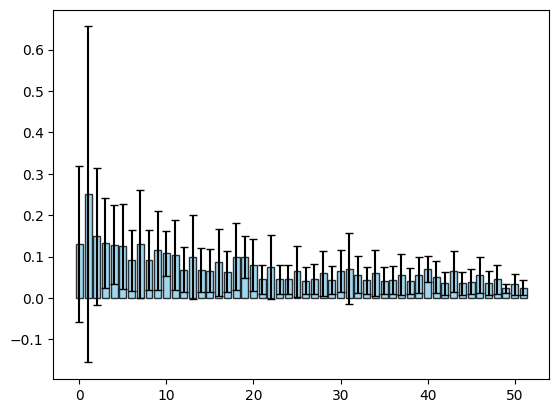

In [8]:
plt.bar(
        range(len(weight_means)),
        weight_means,
        yerr=weight_stds,
        capsize=3,
        color="skyblue",
        alpha=0.8,
        edgecolor="black",
        )

<BarContainer object of 52 artists>

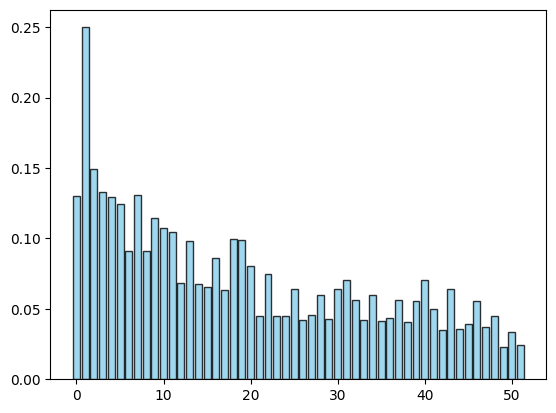

In [9]:
plt.bar(
        range(len(weight_means)),
        weight_means,
        capsize=3,
        color="skyblue",
        alpha=0.8,
        edgecolor="black",
        )

## Sensitivity Analysis

### Scaling-based Pruning

In [22]:
with open('../runs/scaling_pruning/sensivity_analysis.json', 'r') as f:
    data = json.load(f)

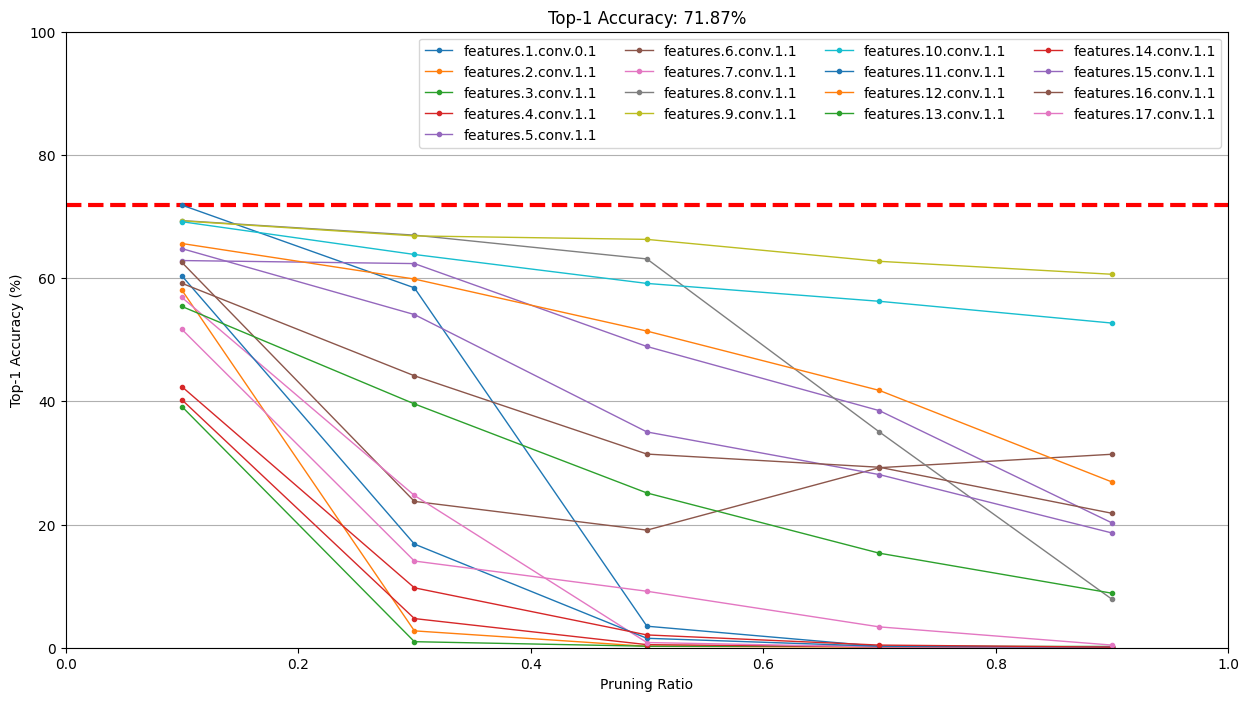

In [23]:
plot_sensitivity_analysis(data, acc_type="top1")

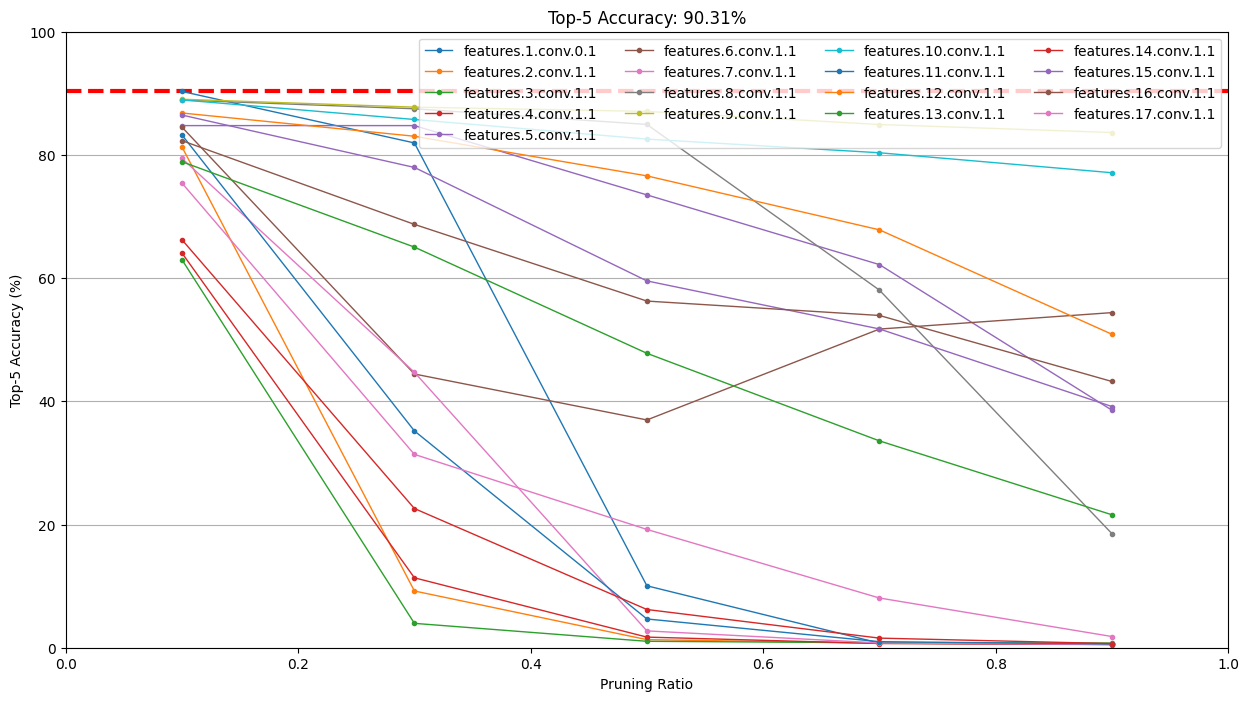

In [18]:
plot_sensitivity_analysis(data, acc_type="top5")

### Scaling-based Pruning

In [19]:
with open('../runs/magnitude_pruning/sensivity_analysis.json', 'r') as f:
    data = json.load(f)

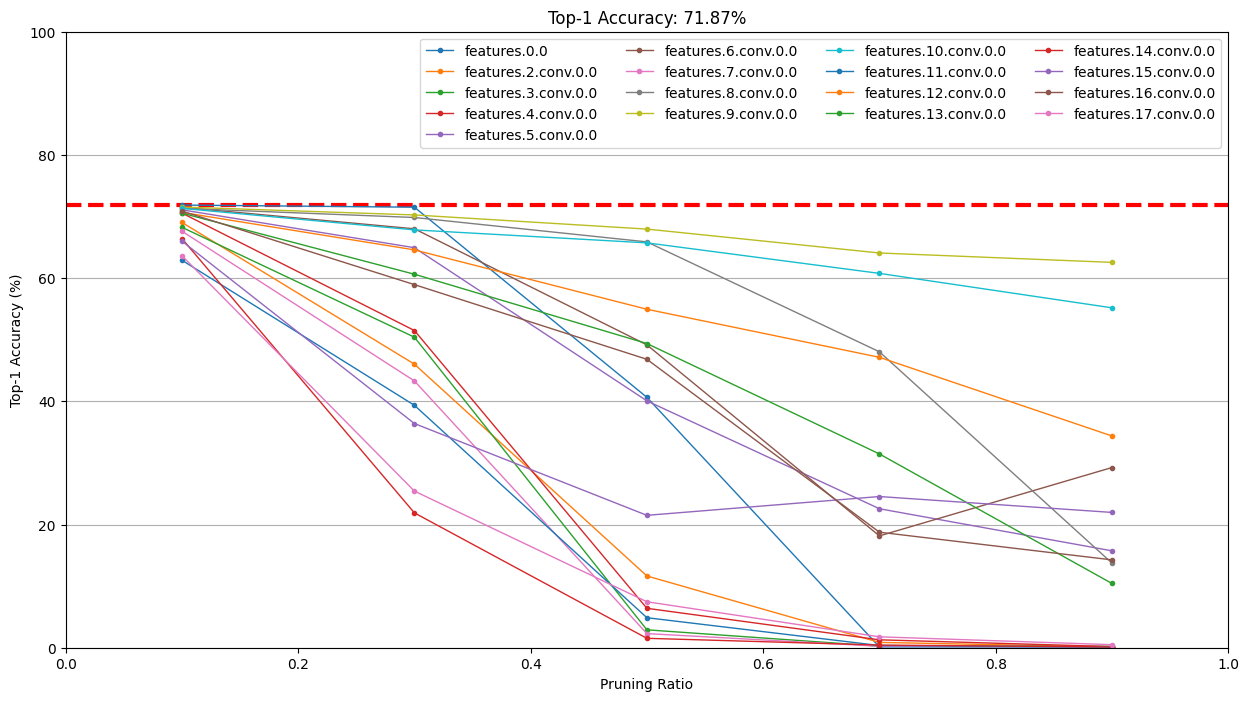

In [20]:
plot_sensitivity_analysis(data, acc_type="top1")

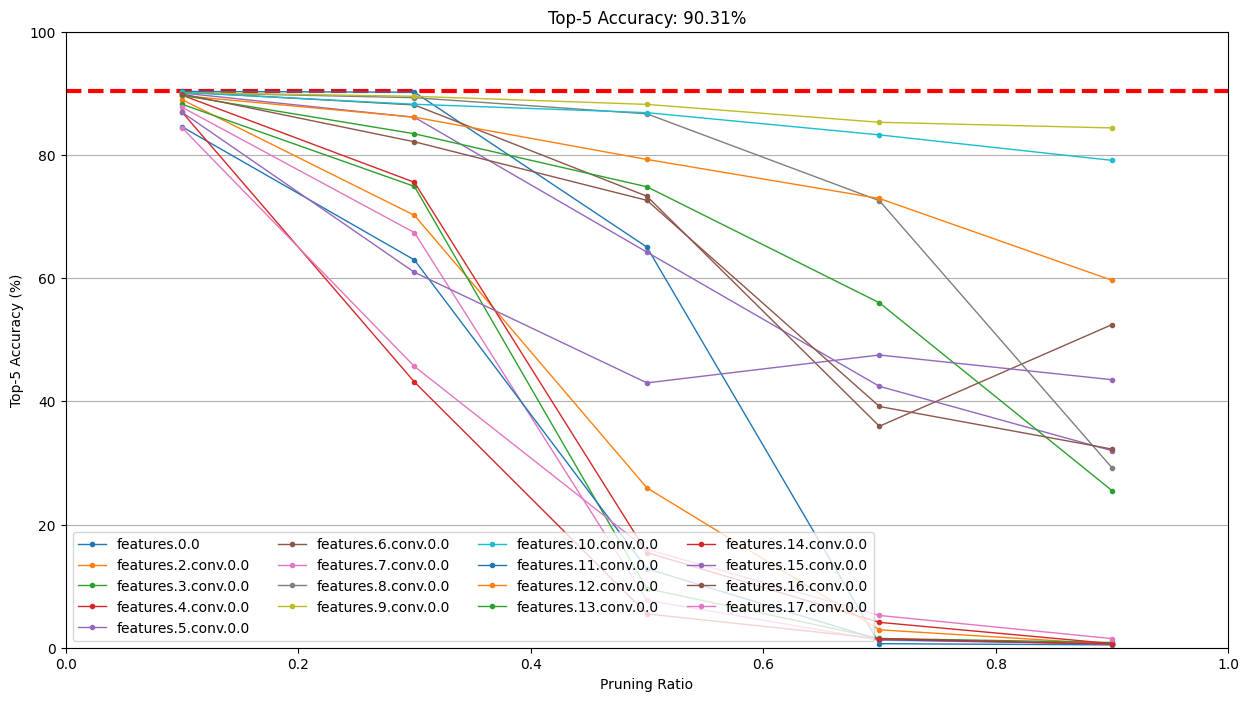

In [21]:
plot_sensitivity_analysis(data, acc_type="top5")

## Interactive Plots

In [ ]:
!python ../utils/interactive_plot.py --pruning-type batchnorm --acc-type top1 --root ../
!python ../utils/interactive_plot.py --pruning-type batchnorm --acc-type top5 --root ../

In [1]:
!python ../utils/interactive_plot.py --pruning-type magnitude --acc-type top1 --root ../
!python ../utils/interactive_plot.py --pruning-type magnitude --acc-type top5 --root ../

## Count Parameters

In [15]:
def plot_cp(data, label, alpha=1.0):
    plt.bar(range(len(data.keys())),
            data.values(),
            capsize=3,
            # color=color,
            alpha=alpha,
            edgecolor="black",
            label=label
            )

def iter_ratios(pruned_layers, pruning_ratios, pruning_type):
    for r in pruning_ratios:
        model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1').to(DEVICE).eval()
        pruning = Pruning(model, DEVICE)
        if pruning_type == 'batchnorm':
            model = pruning.scaling_based_pruning(batch_norms=pruned_layers, pruning_ratio=r, level='global', scale_threshold=False)
        elif pruning_type == 'magnitude':
            model = pruning.magnitude_based_pruning(conv_layers=pruned_layers, pruning_ratio=r, level='global', scale_threshold=False)

        data, total = pruning.count_parameters()
        
        plot_cp(data, label=f"ratio: {r} total: {total/1e6:.3}M", alpha = 1.0)
        
    plt.yscale("log")
    plt.ylabel("#Parameter")
    plt.xlabel("Conv Layer")
    plt.legend()
    plt.show()
    

features.1.conv.0.1 features.2.conv.1.1 features.3.conv.1.1 features.4.conv.1.1 features.5.conv.1.1 features.6.conv.1.1 features.7.conv.1.1 features.8.conv.1.1 features.9.conv.1.1 features.10.conv.1.1 features.11.conv.1.1 features.12.conv.1.1 features.13.conv.1.1 features.14.conv.1.1 features.15.conv.1.1 features.16.conv.1.1 features.17.conv.1.1
32    96    144   144   192   192   192   384   384   384   384   576   576   576   960   960   960  
23    94    137   144   181   178   191   344   317   313   378   514   501   519   896   875   818  
----------------------------------------------------------------------------------------------------
9     2     7     0     11    14    1     40    67    71    6     62    75    57    64    85    142  
features.1.conv.0.1 features.2.conv.1.1 features.3.conv.1.1 features.4.conv.1.1 features.5.conv.1.1 features.6.conv.1.1 features.7.conv.1.1 features.8.conv.1.1 features.9.conv.1.1 features.10.conv.1.1 features.11.conv.1.1 features.12.conv.1.1 fe

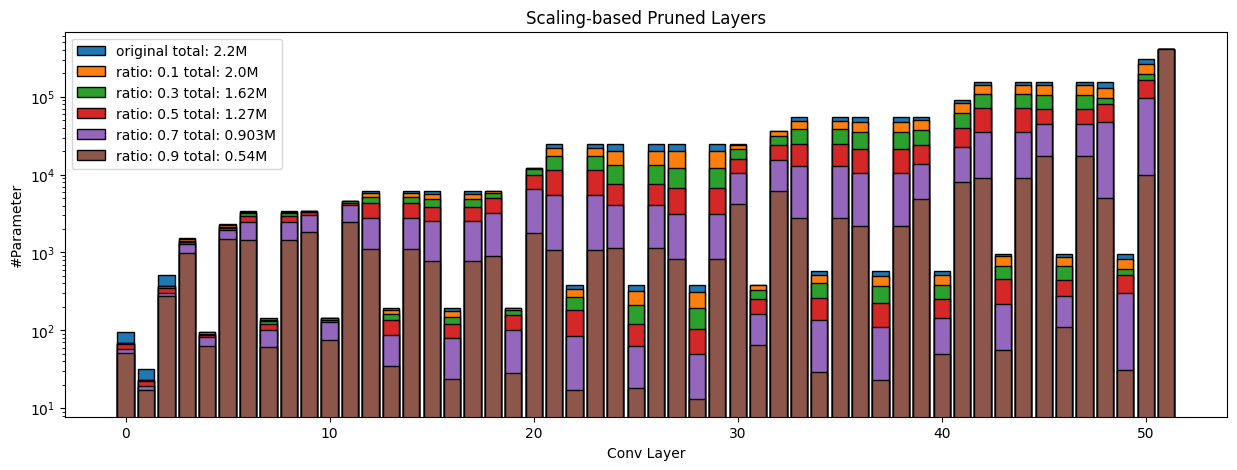

In [20]:
pruning_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(15, 5))
plt.title("Scaling-based Pruned Layers")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1').to(DEVICE).eval()
pruning = Pruning(model, DEVICE)
data, total = pruning.count_parameters()

plot_cp(data, label=f"original total: {total/1e6:.2}M")

pruned_layers = []
for i in range(1, 18):
    if i == 1:
        pruned_layers.append(f'features.{i}.conv.0.1')
        continue    
    pruned_layers.append(f'features.{i}.conv.1.1')

iter_ratios(pruned_layers, pruning_ratios, pruning_type='batchnorm')

features.0.0 features.2.conv.0.0 features.3.conv.0.0 features.4.conv.0.0 features.5.conv.0.0 features.6.conv.0.0 features.7.conv.0.0 features.8.conv.0.0 features.9.conv.0.0 features.10.conv.0.0 features.11.conv.0.0 features.12.conv.0.0 features.13.conv.0.0 features.14.conv.0.0 features.15.conv.0.0 features.16.conv.0.0 features.17.conv.0.0
32    96    144   144   192   192   192   384   384   384   384   576   576   576   960   960   960  
20    26    35    99    42    34    165   329   348   355   384   569   569   573   960   956   959  
----------------------------------------------------------------------------------------------------
12    70    109   45    150   158   27    55    36    29    0     7     7     3     0     4     1    
features.0.0 features.2.conv.0.0 features.3.conv.0.0 features.4.conv.0.0 features.5.conv.0.0 features.6.conv.0.0 features.7.conv.0.0 features.8.conv.0.0 features.9.conv.0.0 features.10.conv.0.0 features.11.conv.0.0 features.12.conv.0.0 features.13.conv

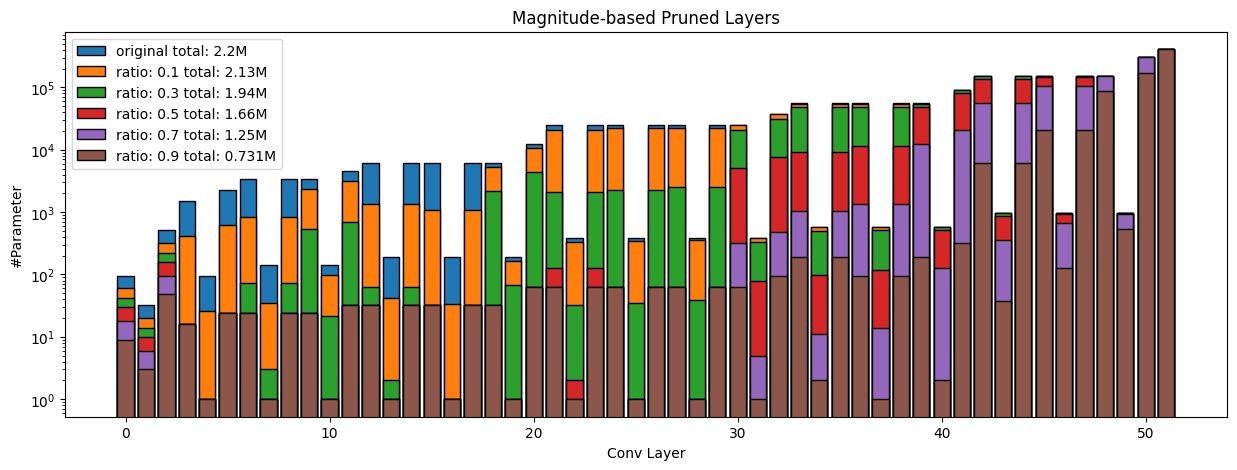

In [19]:
pruning_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(15, 5))
plt.title("Magnitude-based Pruned Layers")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1').to(DEVICE).eval()
pruning = Pruning(model, DEVICE)
data, total = pruning.count_parameters()

plot_cp(data, label=f"original total: {total/1e6:.2}M")

pruned_layers = []
for i in range(0, 18):
    if i == 0:
        pruned_layers.append(f'features.{i}.0')
        continue
    if i == 1:
        continue
    pruned_layers.append(f'features.{i}.conv.0.0')

iter_ratios(pruned_layers, pruning_ratios, pruning_type="magnitude")